## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-1-clean-polish/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_4/'
fold_n = 4
# Unzip files
!tar -xf /kaggle/input/jigsaw-data-split-roberta-192-ratio-1-clean-polish/fold_4.tar.gz

Train samples: 267220


,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,It would be helpful if either story about this incident contained additional facts about what happened. Was the vict...,0.2000,248,41,57,0,train,train,validation,train,train
1,What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm no...,0.0000,610,109,146,0,train,train,validation,train,train
2,Great another mediocre season.,0.6000,30,4,8,1,train,train,validation,train,train
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no proble...",0.6562,170,30,49,1,validation,train,train,train,train
4,"Just call me Nemo.... I'm writing about the HB visa program and so is the author of the article. There are , opening...",0.0000,311,60,85,0,train,train,train,train,validation


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,es,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",it,0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",es,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,tr,0


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'MAX_LEN': 192,
 'BATCH_SIZE': 128,
 'EPOCHS': 3,
 'LEARNING_RATE': 1e-05,
 'ES_PATIENCE': None,
 'base_model_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/tf-xlm-roberta-large-tf_model.h5',
 'config_path': '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/xlm-roberta-large-config.json'}

## Learning rate schedule

Learning rate schedule: 0 to 9.96e-06 to 1.66e-06


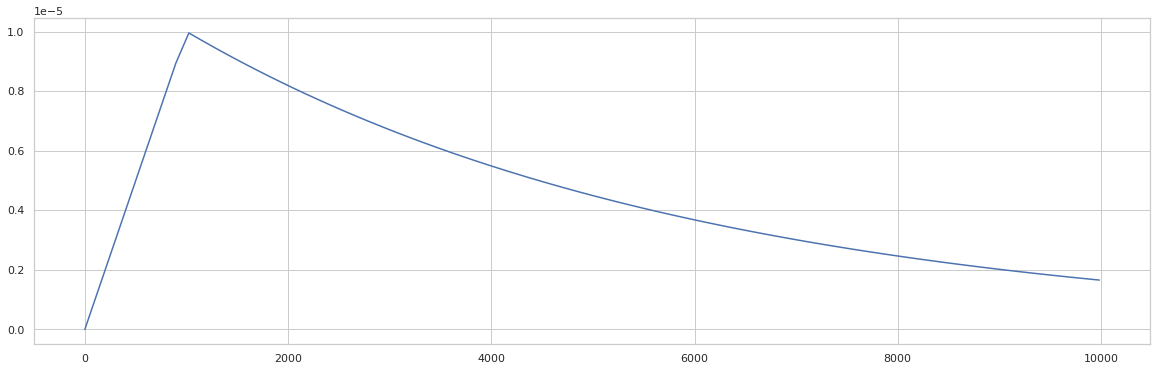

In [5]:
lr_min = 1e-7
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = (len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = total_steps * 0.1
decay = .9998

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, 
                                      hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)
N_SAMPLES = 8

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_avg = layers.GlobalAveragePooling1D()(last_hidden_state)
    x_max = layers.GlobalMaxPooling1D()(last_hidden_state)
    x = layers.Concatenate()([x_avg, x_max])
    
    samples = []
    sample_mask = layers.Dense(64, activation='relu')
    for n in range(N_SAMPLES):
        sample = layers.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = layers.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = layers.Average(name='output')(samples)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid_int.npy').reshape(x_valid.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train_tail = np.load(base_data_path + 'x_train_tail.npy')
y_train_tail = np.load(base_data_path + 'y_train_int_tail.npy').reshape(x_train_tail.shape[1], 1).astype(np.float32)
x_train = np.hstack([x_train, x_train_tail])
y_train = np.vstack([y_train, y_train_tail])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
valid_2_step_size = x_valid.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
valid_2_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)
valid_2_data_iter = iter(valid_2_dist_ds)

In [8]:
# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

@tf.function
def valid_2_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_2_auc.update_state(y, probabilities)
        valid_2_loss.update_state(loss)
    for _ in tf.range(valid_2_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

In [9]:
# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    
    lr = lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                  warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                                  lr_start=lr_start, lr_max=lr_max, lr_min=lr_min, decay=decay)
    
    optimizer = optimizers.Adam(learning_rate=lr)
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    valid_2_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    valid_2_loss = metrics.Sum()
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 192)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober ((None, 192, 1024),  559890432   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tfxlm_roberta_model[0][0]    

In [10]:
metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc, 
                'val_2_loss': valid_2_loss, 'val_2_auc': valid_2_auc}

history = custom_fit_2(model, metrics_dict, train_step, valid_step, valid_2_step, train_data_iter, 
                       valid_data_iter, valid_2_data_iter, step_size, valid_step_size, valid_2_step_size, 
                       config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
# x_train = np.load(base_data_path + 'x_train.npy')
# x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

# train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
# valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
# k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds

Train for 3340 steps, validate for 62 steps, validate_2 for 417 steps

EPOCH 1/3
time: 1083.2s loss: 0.2610 auc: 0.9574 val_loss: 0.2961 val_auc: 0.9283 val_2_loss: 0.2115 val_2_auc: 0.9757

EPOCH 2/3
time: 919.6s loss: 0.1609 auc: 0.9830 val_loss: 0.3232 val_auc: 0.9215 val_2_loss: 0.2123 val_2_auc: 0.9756

EPOCH 3/3
time: 919.5s loss: 0.1278 auc: 0.9888 val_loss: 0.3299 val_auc: 0.9155 val_2_loss: 0.2169 val_2_auc: 0.9743
Training finished


In [11]:
# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

In [12]:
# Step functions
@tf.function
def train_ml_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(valid_step_size_tail):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

In [13]:
# Fine-tune on validation set
optimizer = optimizers.Adam(learning_rate=3e-6)

history_ml = custom_fit_2(model, metrics_dict, train_ml_step, valid_step, valid_2_step, train_ml_data_iter, 
                          valid_data_iter, valid_2_data_iter, valid_step_size_tail, valid_step_size, valid_2_step_size, 
                          config['BATCH_SIZE'], 2, config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 125 steps, validate for 62 steps, validate_2 for 417 steps

EPOCH 1/2
time: 213.7s loss: 0.2141 auc: 0.9398 val_loss: 0.1664 val_auc: 0.9675 val_2_loss: 0.2553 val_2_auc: 0.9707

EPOCH 2/2
time: 69.7s loss: 0.1604 auc: 0.9669 val_loss: 0.1283 val_auc: 0.9869 val_2_loss: 0.2430 val_2_auc: 0.9688
Training finished


## Model loss graph

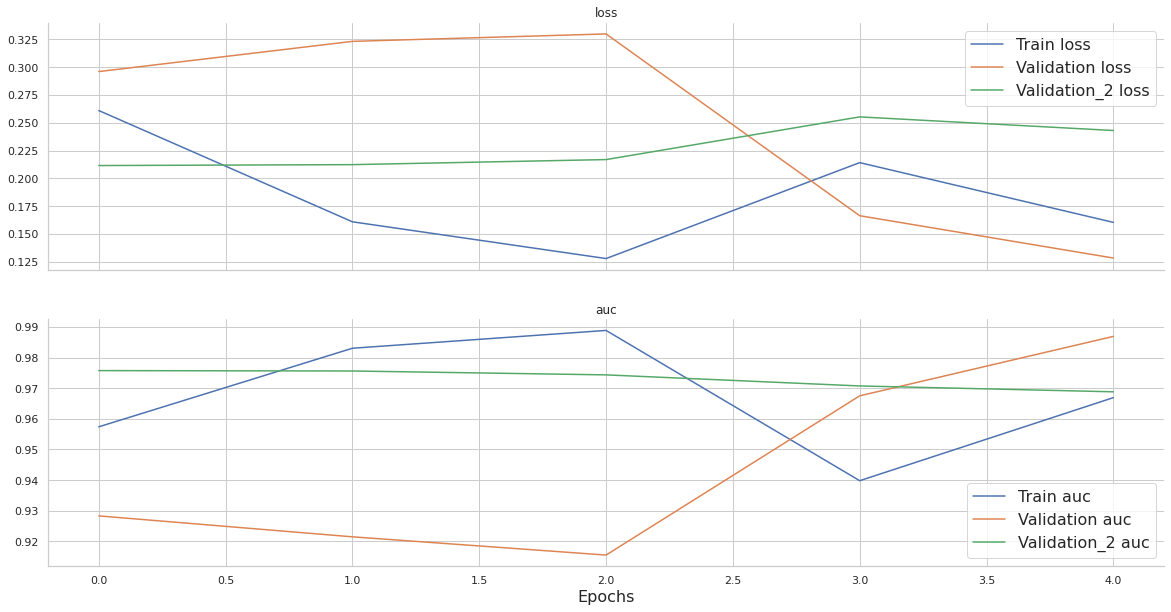

In [14]:
plot_metrics_2(history)

# Model evaluation

In [15]:
# display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

# Confusion matrix

In [16]:
# train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
# validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
# plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
#                       validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [17]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_4
Lang / ROC AUC,,
Overall,0.921714,0.921714
es,0.904678,0.904678
it,0.886119,0.886119
tr,0.973848,0.973848


,Mean,Fold_4
Lang / ROC AUC,,
Overall,0.985755,0.985755
es,0.977553,0.977553
it,0.978395,0.978395
tr,0.996521,0.996521


# Visualize predictions

In [18]:
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,It would be helpful if either story about this incident contained additional facts about what happened. Was the vict...,0.2000
1,What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm no...,0.0000
2,Great another mediocre season.,0.6000
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no proble...",0.6562
4,"Just call me Nemo.... I'm writing about the HB visa program and so is the author of the article. There are , opening...",0.0000
5,"you are an incredible optimist. You see shiny bright full, I see dark clouds obscuring the edge that humans are tott...",0.0000
6,What about Junior's vacation investigation; Morneau and his conflicts of interest; Junior's and Morneau's hidden mon...,0.6000
7,"If you are not well later in life, you need the extra money to cover home care or a residence. Or perhaps, you are h...",0.0000
8,"scuppers.. Facts and reality won't help your case. You'll need to get into the gutter with false facts, false accusa...",1.0000
9,"Yes, electoral districts that voted for Trump had higher median incomes. No, they did not have more education So the...",0.0000


Multilingual validation set


,comment_text,toxic,pred_4,pred_ml_4
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.9176,0.3871
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.0003,0.0009
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.9157,0.7264
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.0004,0.0003
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.0003,0.0003
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.0003,0.0004
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.0003,0.0002
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.0011,0.0003
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.0004,0.0003
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.0003,0.0004


# Test set predictions

In [19]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [20]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.0000,63812.0000
mean,31905.5000,0.2513
std,18421.0820,0.3358
min,0.0000,0.0002
25%,15952.7500,0.0003
50%,31905.5000,0.0071
75%,47858.2500,0.5093
max,63811.0000,0.9999


,id,toxic
0,0,0.0004
1,1,0.0016
2,2,0.4311
3,3,0.0003
4,4,0.0004
5,5,0.3973
6,6,0.0002
7,7,0.0004
8,8,0.0903
9,9,0.3064
